In [1645]:
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
import os
import requests
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import REST, TimeFrame


In [1646]:
# Load .env environment variables
load_dotenv()

True

In [1647]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

In [1648]:
print(f"Alpaca Key type: {type(alpaca_api_key)}")
print(f"Alpaca Secret Key type: {type(alpaca_secret_key)}")

Alpaca Key type: <class 'str'>
Alpaca Secret Key type: <class 'str'>


In [1649]:
# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [1650]:
# create a function to pull stock data from the alpaca api
def get_company(ticker, start, end, tradeapi):
    return alpaca.get_bars(
        ticker,
        TimeFrame.Day,
        start,
        end
    ).df.drop(["trade_count", "vwap"], axis=1)

In [1651]:
# Set your ticker and format start and end dates in iso format
# Set dates to pull 5 years of data
msft_ticker = ["MSFT"]
start= pd.Timestamp("2017-06-01", tz="America/New_York").isoformat()
end= pd.Timestamp("2022-06-01", tz="America/New_York").isoformat()

In [1652]:
# Get stock data for Microsoft
msft_df = get_company(msft_ticker, start, end, tradeapi)

# Drop columns that we will not need
# msft_df= msft_df.drop(["trade_count", "vwap"], axis=1)

# Resample the data to show monthly average
msft_mnth_df = pd.DataFrame(msft_df.resample("M").mean())

# Show microsoft stock data

msft_mnth_df.head()

,open,high,low,close,volume
timestamp,,,,,
2017-06-30 00:00:00+00:00,70.589091,71.014600,69.835727,70.518182,2.876127e+07
2017-07-31 00:00:00+00:00,71.841000,75.105495,69.496500,72.010500,2.349984e+07
2017-08-31 00:00:00+00:00,72.709565,73.196083,72.285187,72.816957,1.932927e+07
2017-09-30 00:00:00+00:00,74.375500,74.786000,73.891000,74.344500,1.885708e+07
2017-10-31 00:00:00+00:00,77.876818,78.349318,77.529773,77.939545,2.053351e+07


In [1653]:
# Create a new df filtering the index and close columns
msft_signals_df = msft_df.loc[:, ["close"]]

# Create a column for the daily returns
msft_signals_df["Actual Returns"] = msft_df["close"].pct_change()

# Drop all NaN values from the DataFrame
msft_signals_df = msft_signals_df.dropna()

# Show signals df
display(msft_signals_df.head())
display(msft_signals_df.tail())

,close,Actual Returns
timestamp,,
2017-06-02 04:00:00+00:00,71.76,0.023680
2017-06-05 04:00:00+00:00,72.28,0.007246
2017-06-06 04:00:00+00:00,72.52,0.003320
2017-06-07 04:00:00+00:00,72.39,-0.001793
2017-06-08 04:00:00+00:00,71.95,-0.006078


,close,Actual Returns
timestamp,,
2022-05-25 04:00:00+00:00,262.52,0.011170
2022-05-26 04:00:00+00:00,265.90,0.012875
2022-05-27 04:00:00+00:00,273.24,0.027604
2022-05-31 04:00:00+00:00,271.87,-0.005014
2022-06-01 04:00:00+00:00,272.42,0.002023


In [1654]:
# set the windows for moving averages
short_window= 20
long_window= 50

# Generate the short and long simple moving averages
msft_signals_df["SMA_short"] = msft_signals_df["close"].rolling(window=short_window).mean()
msft_signals_df["SMA_long"] = msft_signals_df["close"].rolling(window=long_window).mean()
msft_signals_df = msft_signals_df.dropna()
msft_signals_df.head()


,close,Actual Returns,SMA_short,SMA_long
timestamp,,,,
2017-08-11 04:00:00+00:00,72.50,0.015264,73.0250,71.4550
2017-08-14 04:00:00+00:00,73.59,0.015034,73.0370,71.4916
2017-08-15 04:00:00+00:00,73.22,-0.005028,73.0330,71.5104
2017-08-16 04:00:00+00:00,73.65,0.005873,73.0225,71.5330
2017-08-17 04:00:00+00:00,72.40,-0.016972,72.9315,71.5332


<AxesSubplot:xlabel='timestamp'>

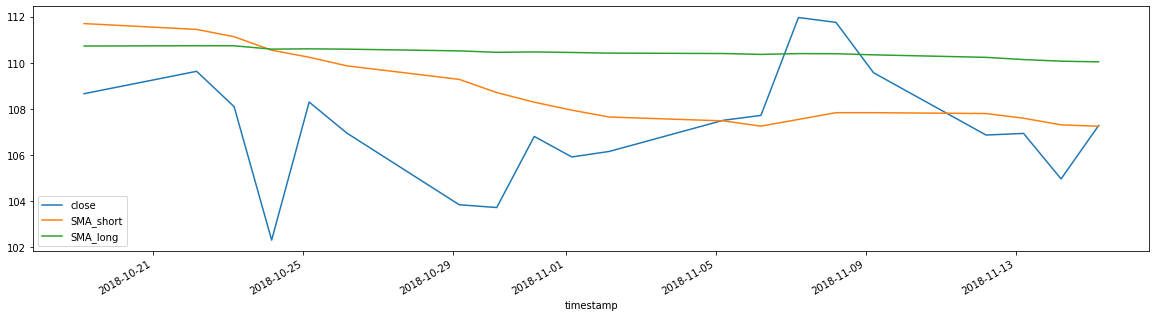

In [1655]:
# Plot the SMA's with the historical close price
# Do these indicators work for our algorithm? What else will work?
msft_signals_df[["close", "SMA_short", "SMA_long"]].iloc[300:320].plot(figsize=(20,5))

In [1656]:
# EWMA indicators
short_span = 12
long_span = 26

msft_ewma_df = msft_df.loc[:, ["close"]]
msft_ewma_df['Short_EWMA'] = msft_ewma_df['close'].ewm(span= short_span).mean()
msft_ewma_df['Long_EWMA'] = msft_ewma_df['close'].ewm(span= long_span).mean()

In [1657]:
# Plot the EWMA indicators
msft_ewma_df[["close", "Short_EWMA", "Long_EWMA"]].iloc[:].hvplot(figsize=(20,5))

:NdOverlay   [Variable]
   :Curve   [timestamp]   (value)

In [1658]:
msft_ewma_df['Signal'] = 0.0
msft_ewma_df['Signal'][short_span:] = np.where(msft_ewma_df['Short_EWMA'][short_span:] > msft_ewma_df['Long_EWMA'][short_span:], 1.0, 0.0)


In [1659]:
msft_ewma_df.head()

,close,Short_EWMA,Long_EWMA,Signal
timestamp,,,,
2017-06-01 04:00:00+00:00,70.10,70.100000,70.100000,0.0
2017-06-02 04:00:00+00:00,71.76,70.999167,70.961923,0.0
2017-06-05 04:00:00+00:00,72.28,71.499076,71.435495,0.0
2017-06-06 04:00:00+00:00,72.52,71.821342,71.738675,0.0
2017-06-07 04:00:00+00:00,72.39,71.975844,71.889720,0.0


In [1660]:
# Set a signal lag for the macd
signal_lag = 9

# Create a function to calculate the macd for 
def mac_d(price, short_span, long_span, signal_lag):
    signal_lag = signal_lag
    ewm_short= price.ewm(span= short_span).mean()
    ewm_long= price.ewm(span= long_span).mean()
    macd = pd.DataFrame(ewm_short - ewm_long).rename(columns= {"close": "macd"})
    macd_sig= pd.DataFrame(macd.ewm(span= signal_lag).mean()).rename(columns= {"macd": "signal_lag"})
    divergence = pd.DataFrame(macd["macd"] - macd_sig["signal_lag"]).rename(columns= {0: "divergence"})
    macd_df = pd.DataFrame()
    macd_df["macd"]= macd["macd"]
    macd_df["signal_lag"]= macd_sig["signal_lag"]
    macd_df["divergence"]= divergence["divergence"]
    return macd_df

# Calculate the MACD for Microsoft stock
msft_macd = mac_d(msft_ewma_df["close"], short_span, long_span, signal_lag)
    
msft_macd  

,macd,signal_lag,divergence
timestamp,,,
2017-06-01 04:00:00+00:00,0.000000,0.000000,0.000000
2017-06-02 04:00:00+00:00,0.037244,0.020691,0.016553
2017-06-05 04:00:00+00:00,0.063581,0.038269,0.025312
2017-06-06 04:00:00+00:00,0.082667,0.053309,0.029358
2017-06-07 04:00:00+00:00,0.086124,0.063070,0.023054
...,...,...,...
2022-05-25 04:00:00+00:00,-7.417124,-7.792367,0.375244
2022-05-26 04:00:00+00:00,-6.553349,-7.544564,0.991214
2022-05-27 04:00:00+00:00,-5.216394,-7.078930,1.862536


In [1661]:
macd_plot = msft_macd[["macd", "signal_lag"]].iloc[200:300].hvplot()
macd_bar = msft_macd[["divergence"]].iloc[200:300].hvplot.bar()
msft_price = msft_ewma_df["close"].iloc[200:300].hvplot()
macd_plot

:NdOverlay   [Variable]
   :Curve   [timestamp]   (value)

In [1662]:
# Create a macd signal column for microsoft
msft_ewma_df['macd_Signal'] = 0.0
msft_ewma_df['macd_Signal'][signal_lag:] = np.where(
    msft_macd['macd'][signal_lag:]> msft_macd['signal_lag'][signal_lag:], 1.0, 0.0
)

msft_ewma_df

,close,Short_EWMA,Long_EWMA,Signal,macd_Signal
timestamp,,,,,
2017-06-01 04:00:00+00:00,70.10,70.100000,70.100000,0.0,0.0
2017-06-02 04:00:00+00:00,71.76,70.999167,70.961923,0.0,0.0
2017-06-05 04:00:00+00:00,72.28,71.499076,71.435495,0.0,0.0
2017-06-06 04:00:00+00:00,72.52,71.821342,71.738675,0.0,0.0
2017-06-07 04:00:00+00:00,72.39,71.975844,71.889720,0.0,0.0
...,...,...,...,...,...
2022-05-25 04:00:00+00:00,262.52,261.959304,269.376428,0.0,1.0
2022-05-26 04:00:00+00:00,265.90,262.565565,269.118915,0.0,1.0
2022-05-27 04:00:00+00:00,273.24,264.207786,269.424180,0.0,1.0


In [1663]:
msft_ewma_df["Combined_Signal"]= msft_ewma_df["Signal"] + (msft_ewma_df["macd_Signal"])

def final_signal(df):
    if df["Combined_Signal"]== 2:
        return 1.0
    else:
        return 0.0
    
msft_ewma_df["Final_Signal"]= msft_ewma_df.apply(final_signal, axis= 1)
    

In [1664]:
msft_ewma_df.sample(60)

,close,Short_EWMA,Long_EWMA,Signal,macd_Signal,Combined_Signal,Final_Signal
timestamp,,,,,,,
2021-11-01 04:00:00+00:00,329.37,315.992525,307.779594,1.0,1.0,2.0,1.0
2019-01-09 05:00:00+00:00,104.27,102.003655,103.193672,0.0,1.0,1.0,0.0
2017-11-09 05:00:00+00:00,84.09,82.933594,80.663287,1.0,1.0,2.0,1.0
2018-04-13 04:00:00+00:00,93.08,91.960437,91.922613,1.0,1.0,2.0,1.0
2019-10-28 04:00:00+00:00,144.19,139.657317,138.884958,1.0,1.0,2.0,1.0
2018-01-22 05:00:00+00:00,91.61,89.056823,87.501490,1.0,1.0,2.0,1.0
2018-07-05 04:00:00+00:00,99.76,99.528485,99.451748,1.0,0.0,1.0,0.0
2018-06-20 04:00:00+00:00,101.87,100.866526,99.715612,1.0,0.0,1.0,0.0
2021-05-20 04:00:00+00:00,246.48,246.374591,247.972746,0.0,0.0,0.0,0.0


In [1707]:
msft_ewma_df['Entry/Exit'] = msft_ewma_df['Final_Signal'].diff()

msft_ewma_macd_df= msft_ewma_df[["Short_EWMA","Long_EWMA","Final_Signal"]].copy()

df = [msft_ewma_macd_df, msft_macd]

msft_ewma_macd_df= pd.concat(df)

# msft_ewma_macd_df.to_csv("../data/MSFT_EWMA_MACD_signals.csv")

In [1666]:
msft_ewma_df.head(50)

,close,Short_EWMA,Long_EWMA,Signal,macd_Signal,Combined_Signal,Final_Signal,Entry/Exit
timestamp,,,,,,,,
2017-06-01 04:00:00+00:00,70.10,70.100000,70.100000,0.0,0.0,0.0,0.0,NaN
2017-06-02 04:00:00+00:00,71.76,70.999167,70.961923,0.0,0.0,0.0,0.0,0.0
2017-06-05 04:00:00+00:00,72.28,71.499076,71.435495,0.0,0.0,0.0,0.0,0.0
2017-06-06 04:00:00+00:00,72.52,71.821342,71.738675,0.0,0.0,0.0,0.0,0.0
2017-06-07 04:00:00+00:00,72.39,71.975844,71.889720,0.0,0.0,0.0,0.0,0.0
2017-06-08 04:00:00+00:00,71.95,71.969563,71.901794,0.0,0.0,0.0,0.0,0.0
2017-06-09 04:00:00+00:00,70.32,71.601469,71.620480,0.0,0.0,0.0,0.0,0.0
2017-06-12 04:00:00+00:00,69.78,71.221356,71.323933,0.0,0.0,0.0,0.0,0.0
2017-06-13 04:00:00+00:00,70.65,71.108322,71.224041,0.0,0.0,0.0,0.0,0.0


In [1667]:

# (msft_ewma_df['Entry/Exit']== 1).sum()

In [1668]:
exit = msft_ewma_df[msft_ewma_df['Entry/Exit'] == -1.0]['close'].hvplot.scatter(
    color='yellow',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

entry = msft_ewma_df[msft_ewma_df['Entry/Exit'] == 1.0]['close'].hvplot.scatter(
    color='purple',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

security_close = msft_ewma_df[['close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

moving_avgs = msft_ewma_df[['Short_EWMA', 'Long_EWMA']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

entry_exit_plot = security_close * moving_avgs * entry * exit
entry_exit_plot

:Overlay
   .Curve.I          :Curve   [timestamp]   (close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [timestamp]   (value)
   .Scatter.Close.I  :Scatter   [timestamp]   (close)
   .Scatter.Close.II :Scatter   [timestamp]   (close)

In [1669]:
# Set initial capital
initial_capital = float(10000)

# Set the share size
share_size = 140

In [1670]:
msft_ewma_df['Position'] = share_size * msft_ewma_df['Final_Signal']



In [1671]:
msft_ewma_df['Entry/Exit Position'] = msft_ewma_df['Position'].diff()

In [1672]:
msft_ewma_df['Portfolio Holdings'] = msft_ewma_df['close'] * msft_ewma_df['Position']

In [1673]:
msft_ewma_df['Portfolio Cash'] = initial_capital - (msft_ewma_df['close'] * msft_ewma_df['Entry/Exit Position']).cumsum() 

In [1674]:
msft_ewma_df['Portfolio Total'] = msft_ewma_df['Portfolio Cash'] + msft_ewma_df['Portfolio Holdings']

In [1675]:
msft_ewma_df['Portfolio Daily Returns'] = msft_ewma_df['Portfolio Total'].pct_change()

In [1676]:
msft_ewma_df['Portfolio Cumulative Returns'] = (1 + msft_ewma_df['Portfolio Daily Returns']).cumprod() - 1

In [1677]:
msft_ewma_df.tail(50)

,close,Short_EWMA,Long_EWMA,Signal,macd_Signal,Combined_Signal,Final_Signal,Entry/Exit,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
timestamp,,,,,,,,,,,,,,,
2022-03-22 04:00:00+00:00,304.06,293.674438,294.045831,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,19098.6,19098.6,0.000000,0.90986
2022-03-23 04:00:00+00:00,299.49,294.569140,294.449103,1.0,1.0,2.0,1.0,1.0,140.0,140.0,41928.6,-22830.0,19098.6,0.000000,0.90986
2022-03-24 04:00:00+00:00,304.10,296.035426,295.163984,1.0,1.0,2.0,1.0,0.0,140.0,0.0,42574.0,-22830.0,19744.0,0.033793,0.97440
2022-03-25 04:00:00+00:00,303.68,297.211515,295.794800,1.0,1.0,2.0,1.0,0.0,140.0,0.0,42515.2,-22830.0,19685.2,-0.002978,0.96852
2022-03-28 04:00:00+00:00,310.70,299.286666,296.898889,1.0,1.0,2.0,1.0,0.0,140.0,0.0,43498.0,-22830.0,20668.0,0.049926,1.06680
2022-03-29 04:00:00+00:00,315.41,301.767179,298.270082,1.0,1.0,2.0,1.0,0.0,140.0,0.0,44157.4,-22830.0,21327.4,0.031904,1.13274
2022-03-30 04:00:00+00:00,313.86,303.627613,299.424891,1.0,1.0,2.0,1.0,0.0,140.0,0.0,43940.4,-22830.0,21110.4,-0.010175,1.11104
2022-03-31 04:00:00+00:00,308.31,304.347980,300.083047,1.0,1.0,2.0,1.0,0.0,140.0,0.0,43163.4,-22830.0,20333.4,-0.036807,1.03334
2022-04-01 04:00:00+00:00,309.42,305.128291,300.774673,1.0,1.0,2.0,1.0,0.0,140.0,0.0,43318.8,-22830.0,20488.8,0.007643,1.04888


In [1694]:
# msft_ewma_df.to_csv("../data/EWMA_MACD_cumret.csv")

In [1679]:
# Creating a datframe for Backtesting results
columns = ["Backtest"]

In [1680]:
metrics = [
    "Annualized Return",
    "Cumulative Returns",
    "Annual Volatility",
    "Sharpe Ratio",
    "Sortino Ratio"]

In [1681]:
portfolio_evaluation_df = pd.DataFrame(index=metrics, columns=columns)

portfolio_evaluation_df

,Backtest
Annualized Return,NaN
Cumulative Returns,NaN
Annual Volatility,NaN
Sharpe Ratio,NaN
Sortino Ratio,NaN


In [1682]:
portfolio_evaluation_df.loc["Annualized Return"] = (
    msft_ewma_df["Portfolio Daily Returns"].mean() * 252
)

portfolio_evaluation_df

,Backtest
Annualized Return,0.168139
Cumulative Returns,NaN
Annual Volatility,NaN
Sharpe Ratio,NaN
Sortino Ratio,NaN


In [1683]:
portfolio_evaluation_df.loc["Cumulative Returns"] = msft_ewma_df["Portfolio Cumulative Returns"][-1]

portfolio_evaluation_df

,Backtest
Annualized Return,0.168139
Cumulative Returns,0.93618
Annual Volatility,NaN
Sharpe Ratio,NaN
Sortino Ratio,NaN


In [1684]:
# Calculate annual volatility
portfolio_evaluation_df.loc["Annual Volatility"] = (
    msft_ewma_df["Portfolio Daily Returns"].std() * np.sqrt(252)
)

# Review the result
portfolio_evaluation_df

,Backtest
Annualized Return,0.168139
Cumulative Returns,0.93618
Annual Volatility,0.26746
Sharpe Ratio,NaN
Sortino Ratio,NaN


In [1685]:
# Calculate Sharpe ratio
portfolio_evaluation_df.loc["Sharpe Ratio"] = (
    msft_ewma_df["Portfolio Daily Returns"].mean() * 252) / (
    msft_ewma_df["Portfolio Daily Returns"].std() * np.sqrt(252)
)

# Review the result
portfolio_evaluation_df

,Backtest
Annualized Return,0.168139
Cumulative Returns,0.93618
Annual Volatility,0.26746
Sharpe Ratio,0.628651
Sortino Ratio,NaN


In [1693]:
# Create a DataFrame that contains the Portfolio Daily Returns column
sortino_ratio_df = msft_ewma_df[["Portfolio Daily Returns"]].copy()

# Create a column to hold downside return values
sortino_ratio_df.loc[:,"Downside Returns"] = 0

# Find Portfolio Daily Returns values less than 0,
# square those values, and add them to the Downside Returns column
sortino_ratio_df.loc[sortino_ratio_df["Portfolio Daily Returns"] < 0,
                     "Downside Returns"] = sortino_ratio_df["Portfolio Daily Returns"]**2

# Review the DataFrame
sortino_ratio_df.head(60)

,Portfolio Daily Returns,Downside Returns
timestamp,,
2017-06-01 04:00:00+00:00,NaN,0.000000e+00
2017-06-02 04:00:00+00:00,NaN,0.000000e+00
2017-06-05 04:00:00+00:00,0.000000,0.000000e+00
2017-06-06 04:00:00+00:00,0.000000,0.000000e+00
2017-06-07 04:00:00+00:00,0.000000,0.000000e+00
2017-06-08 04:00:00+00:00,0.000000,0.000000e+00
2017-06-09 04:00:00+00:00,0.000000,0.000000e+00
2017-06-12 04:00:00+00:00,0.000000,0.000000e+00
2017-06-13 04:00:00+00:00,0.000000,0.000000e+00


In [1687]:
# Calculate the annualized return value
annualized_return = (
    sortino_ratio_df["Portfolio Daily Returns"].mean() * 252
)

# Print the result
print(f"Annualized Return: {annualized_return}")

Annualized Return: 0.1681391525794743


In [1688]:
downside_standard_deviation = (
    np.sqrt(sortino_ratio_df["Downside Returns"].mean()) * np.sqrt(252)
)

# Print the result
print(f"Annualized Downside STD: {downside_standard_deviation}")

Annualized Downside STD: 0.18143300830683065


In [1689]:
# The Sortino ratio is reached by dividing the annualized return value
# by the downside standard deviation value
sortino_ratio = annualized_return/downside_standard_deviation

# Add the Sortino ratio to the evaluation DataFrame
portfolio_evaluation_df.loc["Sortino Ratio"] = sortino_ratio

# Review the DataFrame
portfolio_evaluation_df

,Backtest
Annualized Return,0.168139
Cumulative Returns,0.93618
Annual Volatility,0.26746
Sharpe Ratio,0.628651
Sortino Ratio,0.926729


In [1690]:
trade_evaluation_df = pd.DataFrame(
    columns=[
        "Stock",
        "Entry Date",
        "Exit Date",
        "Shares",
        "Entry Share Price",
        "Exit Share Price",
        "Entry Portfolio Holding",
        "Exit Portfolio Holding",
        "Profit/Loss"]
)

In [1691]:
for index, row in msft_ewma_df.iterrows():
    if row["Entry/Exit"] == 1:
        entry_date = index
        entry_portfolio_holding = row["Portfolio Holdings"]
        share_size = row["Entry/Exit Position"]
        entry_share_price = row["close"]

    elif row["Entry/Exit"] == -1:
        exit_date = index
        exit_portfolio_holding = abs(row["close"] * row["Entry/Exit Position"])
        exit_share_price = row["close"]
        profit_loss = exit_portfolio_holding - entry_portfolio_holding
        trade_evaluation_df = trade_evaluation_df.append(
            {
                "Stock": "MSFT",
                "Entry Date": entry_date,
                "Exit Date": exit_date,
                "Shares": share_size,
                "Entry Share Price": entry_share_price,
                "Exit Share Price": exit_share_price,
                "Entry Portfolio Holding": entry_portfolio_holding,
                "Exit Portfolio Holding": exit_portfolio_holding,
                "Profit/Loss": profit_loss
            },
            ignore_index=True)

# Print the DataFrame
trade_evaluation_df

,Stock,Entry Date,Exit Date,Shares,Entry Share Price,Exit Share Price,Entry Portfolio Holding,Exit Portfolio Holding,Profit/Loss
0,MSFT,2017-07-13 04:00:00+00:00,2017-07-31 04:00:00+00:00,140.0,71.77,72.70,10047.8,10178.0,130.2
1,MSFT,2017-08-30 04:00:00+00:00,2017-09-21 04:00:00+00:00,140.0,74.01,74.21,10361.4,10389.4,28.0
2,MSFT,2017-10-05 04:00:00+00:00,2017-11-13 05:00:00+00:00,140.0,75.97,83.93,10635.8,11750.2,1114.4
3,MSFT,2017-12-12 05:00:00+00:00,2017-12-26 05:00:00+00:00,140.0,85.58,85.40,11981.2,11956.0,-25.2
4,MSFT,2018-01-04 05:00:00+00:00,2018-02-05 05:00:00+00:00,140.0,87.11,88.00,12195.4,12320.0,124.6
5,MSFT,2018-02-20 05:00:00+00:00,2018-03-15 04:00:00+00:00,140.0,92.72,94.18,12980.8,13185.2,204.4
6,MSFT,2018-04-13 04:00:00+00:00,2018-04-30 04:00:00+00:00,140.0,93.08,93.52,13031.2,13092.8,61.6
7,MSFT,2018-05-01 04:00:00+00:00,2018-05-02 04:00:00+00:00,140.0,95.00,93.51,13300.0,13091.4,-208.6
8,MSFT,2018-05-07 04:00:00+00:00,2018-05-18 04:00:00+00:00,140.0,96.22,96.36,13470.8,13490.4,19.6
9,MSFT,2018-05-23 04:00:00+00:00,2018-06-13 04:00:00+00:00,140.0,98.66,100.85,13812.4,14119.0,306.6
